## Exploring a single simulation

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
from datetime import timedelta as delta
from matplotlib.animation import FuncAnimation, writers, PillowWriter
from copy import copy
import cmocean
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [6]:
datadir = '/scratch/rfischer/Kooi_data/'#data_output/
regions = {'EqPac': 'Equatorial Pacific',
           'GPGP': 'Great Pacific Garbage Patch',
           'SO': 'Southern Ocean',
           'NPSG': 'North Pacific Subtropical Gyre'}

In [7]:
r_pl_clist = ['#fbb4b9', '#f768a1', '#c51b8a', '#7a0177']
r_pl_cmap = plt.get_cmap('RdPu_r')

mixing_cmap = ['firebrick','seagreen','purple']
w_vel_cmap = ['orangered', 'lime', 'cornflowerblue', 'gold']

In [8]:
region = 'EqPac'
mortality = 0.39              # [d-1]
runtime = 80                  # [days]
dt = 60                       # [seconds]
outputdt = 12                 # [hours]
mixing = 'markov_0_KPP_reflect_tidal'
rho_p = 920
sizebinedges = [1e-3, 0.5e-3, 1e-4, 1e-5, 1e-6]

In [9]:
# ds = xr.open_dataset(datadir+'regional_GPGP_bfadv_Jan_2004_3D_grid2x2_allrho_allr_20days_60dtsecs_12hrsoutdt.nc')
ds = xr.open_dataset(datadir+'regional_'+region+'_bfadv_Jan_2004_0'+str(mortality)[2:]+'mort_'+mixing+'mixing_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc')

In [10]:
times = ds['time'][0,:].astype('O')
timelabels = ds['time'][0,:].dt.strftime('%Y-%m-%d')

In [11]:
number_of_trajectories_to_plot = 125
n_plt = number_of_trajectories_to_plot
f_plt = int(np.round(len(ds['traj'])/n_plt))
print('plotting '+str(n_plt)+' of '+str(len(ds['traj']))+' trajectories')
print('plotting every '+str(f_plt)+' particles')

plotting 125 of 10000 trajectories
plotting every 80 particles


In [12]:
lons = copy(ds['lon'][:].values)
lats = copy(ds['lat'][:].values)
depths = copy(ds['z'][:].values)

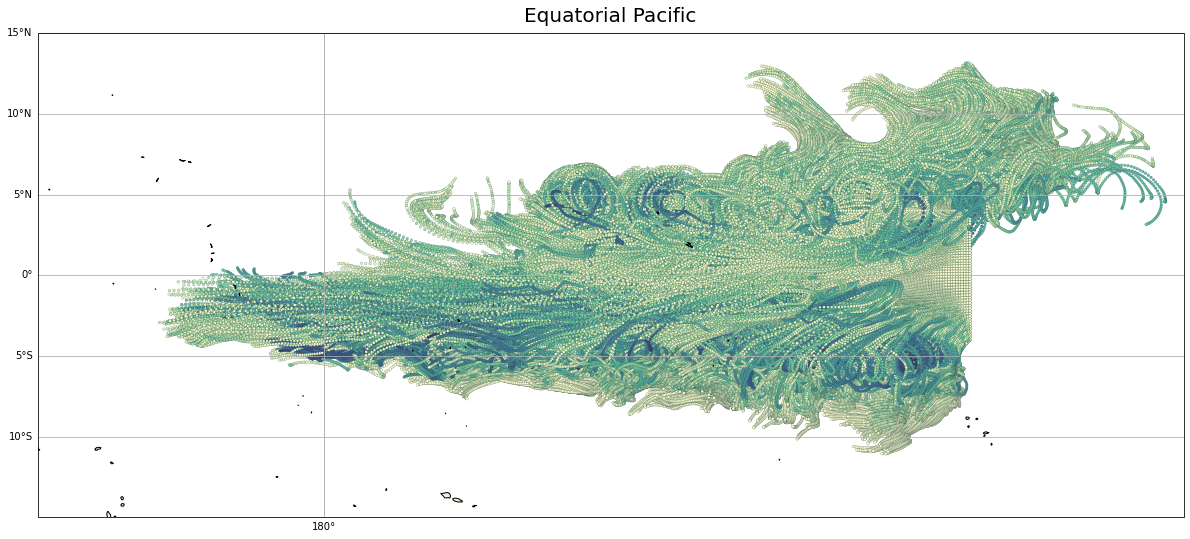

In [15]:
fig = plt.figure(figsize=(16,8), constrained_layout=True)
ax = plt.axes(projection=ccrs.PlateCarree(180))

ax.set_title(regions[region], fontsize=20)
ax.scatter(lons,lats,c=depths,cmap='cmo.deep',s=7, edgecolor='darkslategray',linewidth=0.2, transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([165,240,-15,15], crs=ccrs.PlateCarree())
ax.set_ylim(np.mean(ds['lat'])-15,np.mean(ds['lat'])+15)
ax.set_xlim(np.mean(ds['lon'].where(ds['lon']<0))-45+180,np.mean(ds['lon'].where(ds['lon']<0))+26+180)
plt.show()

In [10]:
outputdt = delta(hours=12)
timerange = np.arange(np.nanmin(ds['time'].values),
                      np.nanmax(ds['time'].values)+np.timedelta64(outputdt), 
                      outputdt)  # timerange in nanoseconds
timedays = np.zeros(len(timerange), dtype='<U10')
for i in range(len(timerange)):
    timedays[i] = str(timerange[i])[:10]
timedays = np.unique(timedays)

In [11]:
time_id = np.where(np.logical_and(ds['time'] >= timerange[0],ds['time'] < timerange[1])) # All trajectory data for a single day


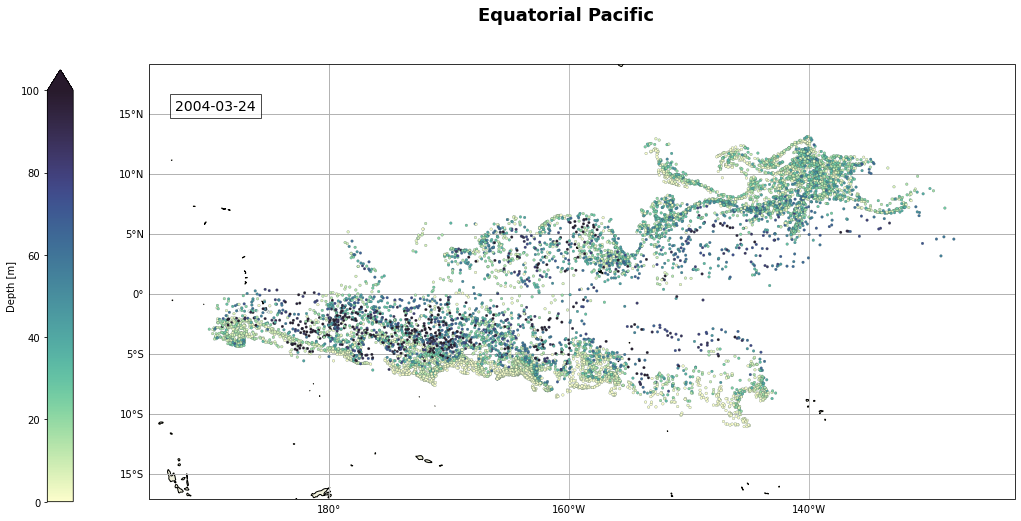

In [17]:
fig = plt.figure(figsize=(18,8))
fig.suptitle(regions[region], fontsize=18, fontweight='bold')
ax = plt.axes(projection=ccrs.PlateCarree(180))

ax.set_ylim(np.mean(ds['lat'])-15,np.mean(ds['lat'])+15)
ax.set_xlim(np.mean(ds['lon'].where(ds['lon']<0))-45+180,np.mean(ds['lon'].where(ds['lon']<0))+26+180)

# ax.set_yticks([-50, -40, -30, -20], crs=ccrs.PlateCarree())
# ax.set_yticklabels(['50$^{\circ}$S', '40$^{\circ}$S', '30$^{\circ}$S', '20$^{\circ}$S'])
# ax.set_ylabel('Latitude', fontsize=11, fontweight='bold')

# ax.set_xticks([-50, -40, -30, -20, -10, 0, 10, 20], crs=ccrs.PlateCarree())
# ax.set_xticklabels(['50$^{\circ}$W', '40$^{\circ}$W', '30$^{\circ}$W', '20$^{\circ}$W', '10$^{\circ}$W', '0$^{\circ}$E', '10$^{\circ}$E', '20$^{\circ}$E'])
# ax.set_xlabel('Longitude', fontsize=11, fontweight='bold')

# depth = ax.pcolormesh(lon_bath_corners, lat_bath_corners, Depth, cmap=b_cmap,vmax =5000,zorder=2)
# ax.pcolormesh(lon_corners, lat_corners, speed, cmap=f_cmap,zorder=1)

# ax.pcolor(lon_corners, lat_corners, Coast,cmap=c_cmap,hatch='//',edgecolor='coral',zorder=3)
# coastcells = mpatches.Patch(facecolor='w',hatch='//',edgecolor='coral', label='Coastal cells')

ax.coastlines()
ax.add_feature(cfeature.LAND)

ax.gridlines(draw_labels=False, crs=ccrs.PlateCarree(), xlocs=[120,140,160,180,200,220,240])
gl =ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), xlocs=[120,140,160,180,-160,-140,-120])
gl.top_labels = False
gl.right_labels = False
# gl.xlocator = mticker.FixedLocator([180, -])
# gl.ylocator = LatitudeLocator()
# gl.xformatter = LongitudeFormatter()
# gl.yformatter = LatitudeFormatter()


time_id = np.where(np.logical_and(ds['time'] >= timerange[0],ds['time'] < timerange[1])) # All trajectory data for a single day

# initial = ax.scatter(ds['lon'][:,0],ds['lat'][:,0],c='w',edgecolor='orangered',s=100,zorder=3)
scatter = ax.scatter(lons[time_id].T,lats[time_id].T,c=depths[time_id].T,cmap='cmo.deep',s=7, edgecolor='darkslategray',linewidth=0.2,vmin=0,vmax=100, transform=ccrs.PlateCarree(),zorder=4)

# time_id_TDC = np.where(np.logical_and(TDCdata['time'] >= timerange[0],TDCdata['time'] < timerange[24])) # All trajectory data for a single day

# site_TDC = ax.scatter(lons_TDC[1,0],lats_TDC[1,0],c='w',edgecolor='seagreen',s=100,zorder=3)
# scatter_TDC = ax.scatter(lons_TDC[time_id_TDC].T,lats_TDC[time_id_TDC].T,c=launch_TDC[time_id_TDC],cmap=p_cmap,vmin=-0.5,vmax=0.5,alpha=0.4,edgecolor='seagreen',zorder=4)

# N_site = ax.scatter(lonsN[0,0].T,latsN[0,0].T,c='w',edgecolor='r',s=40,zorder=3)

time_text = ax.text(0.03, 0.92,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=14, bbox={'facecolor':'w', 'alpha':0.7, 'pad':5}) # Initialise time ticker

## Depth colorbar
axcb = fig.add_axes([0.1, 0.12, 0.02, 0.75])
CB = plt.colorbar(scatter, cax=axcb,label='Depth [m]',extend='max')
axcb.yaxis.set_ticks_position('left')
axcb.yaxis.set_label_position('left')

def animate(i):
#     time_id_TDC = np.where(np.logical_and(TDCdata['time'] >= timerange[i*24],TDCdata['time'] < timerange[(i+1)*24]))
#     scatter_TDC.set_offsets(np.c_[lons_TDC[time_id_TDC], lats_TDC[time_id_TDC]])
#     scatter_TDC.set_array(launch_TDC.T[time_id_TDC])
    
    time_id = np.where(np.logical_and(ds['time'] >= timerange[i],ds['time'] < timerange[i+1]))
    scatter.set_offsets(np.c_[lons[time_id].T, lats[time_id].T])
    scatter.set_array(depths[time_id].T)
    
    if i%2==0:
        time_text.set_text(timedays[int(i/2)])  # Update the time
    return scatter, time_text,

# custom_lines = [Line2D([0], [0], c = 'w', marker='o', markerfacecolor='sandybrown', markeredgecolor='orangered', markersize=10),
#                 Line2D([0], [0], c = 'w', marker='o', markerfacecolor='khaki', markeredgecolor='seagreen', markersize=10),
#                 Line2D([0], [0], c = 'w', marker='o', markerfacecolor='w', markeredgecolor='r', markersize=10)]

# ax.legend(custom_lines, ['Falkland Islands','Tristan Da Cunha','Kelp Blue sites'],framealpha=1,loc='lower right')

anim = FuncAnimation(fig, animate, frames = len(timerange)-1, interval=200, blit=True)

writergif = PillowWriter(fps=10, codec="libx264") 
anim.save('test1.gif', writer=writergif)

plt.show()

In [71]:
time_id = np.where(np.logical_and(ds['time'] >= timerange[2],ds['time'] < timerange[2+1]))

In [72]:
np.c_[lons[time_id].T, lats[time_id].T].shape

(10000, 2)

In [73]:
time_id

(array([   0,    1,    2, ..., 9997, 9998, 9999]),
 array([2, 2, 2, ..., 2, 2, 2]))

In [74]:
depths[time_id].T.shape

(10000,)

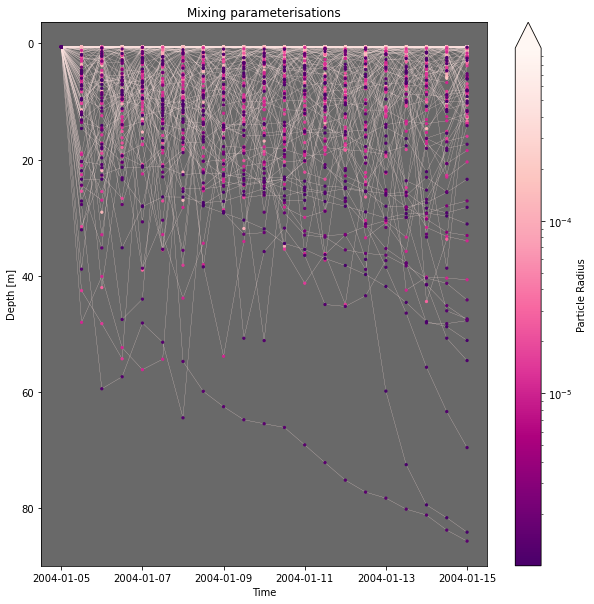

In [9]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()

sc = ax.scatter(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], s=5, c=np.tile(ds['r_pl'].T[::f_plt],[len(ds['obs']),1]),cmap=r_pl_cmap,norm=mcolors.LogNorm(vmin=ds['r_pl'].min(), vmax=ds['r_pl'].max()),zorder=2)
ln = ax.plot(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], c='mistyrose',linewidth=0.2,zorder=1)
ax.set_title('Mixing parameterisations')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Time')
ax.set_facecolor('dimgray')
# ax.set_ylim(150,0)
ax.invert_yaxis()

fig.colorbar(sc, ax=ax, extend='max', label='Particle Radius')
plt.show()

In [16]:
w_bins = [-1e0, -1e-1, -1e-2, -1e-3, -1e-4, -1e-5, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]
w_bincenters = [-2e-1, -2e-2, -2e-3, -2e-4, -2e-5, 0, 2e-5, 2e-4, 2e-3, 2e-2, 2e-1]
w_list = ['w_m', 'vs_init', 'w_adv', 'w_m_b']
w_pdf = np.zeros((len(w_list),len(w_bins)-1))
linestyles=['-','-.']


for j,w in enumerate(w_list):
    vals, bins = np.histogram(ds[w], w_bins)
    w_pdf[j,:] = vals/ds[w].size

In [17]:
w_widths = np.ones(w_pdf.shape[1])
w_centers = np.arange(w_pdf.shape[1])
w_edges = np.arange(w_pdf.shape[1]+1)-0.5
w_bin_str = [np.format_float_scientific(w,2,exp_digits=1) for w in w_bins]

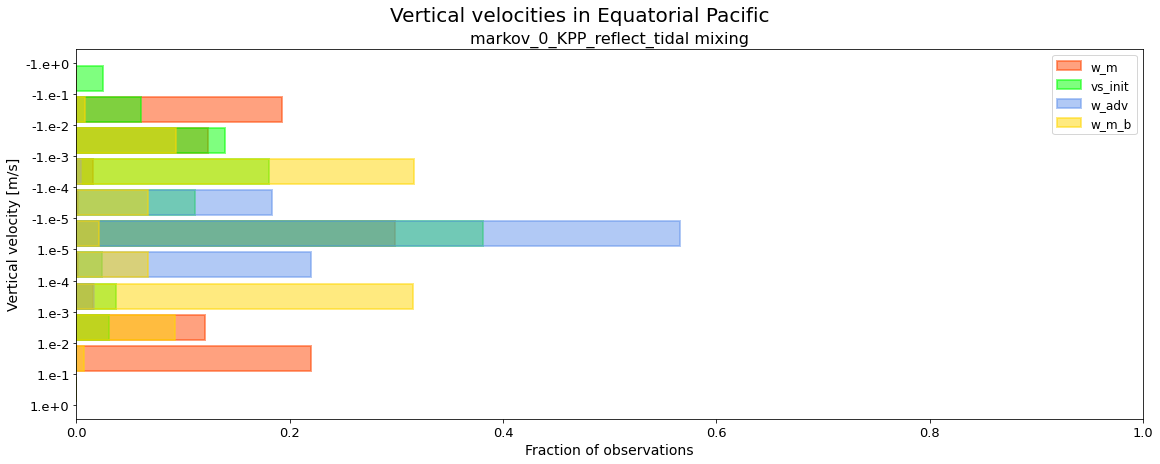

In [18]:
fig = plt.figure(figsize=(16,6),constrained_layout=True)
fig.suptitle('Vertical velocities in '+regions[region], fontsize=20, y=1.05)
ax=plt.axes()

for j,w in enumerate(w_list):
    ax.barh(w_centers, w_pdf[j], align='center', alpha=0.5, color=w_vel_cmap[j], edgecolor=w_vel_cmap[j], linewidth=2, label=w)
ax.set_xlim(0,1.)
ax.set_yticks(w_edges)
ax.set_yticklabels(w_bin_str)
ax.invert_yaxis()
ax.tick_params(axis='both', labelsize=13)
ax.set_xlabel('Fraction of observations', fontsize=14)
ax.set_ylabel('Vertical velocity [m/s]', fontsize=14)
ax.set_title(mixing+' mixing', fontsize=16)
ax.legend(fontsize=12)

In [32]:
w_pdf_sizes = np.zeros((len(w_list),len(sizebinedges)-1,len(w_bins)-1))

split_ds = list(ds.groupby_bins('r_pl',sizebinedges[::-1]))
for j,w in enumerate(w_list):
    for k,ds_r in enumerate(split_ds):
        vals, bins = np.histogram(ds_r[1][w], w_bins)
        w_pdf_sizes[j,k,:] = vals/ds_r[1][w].size

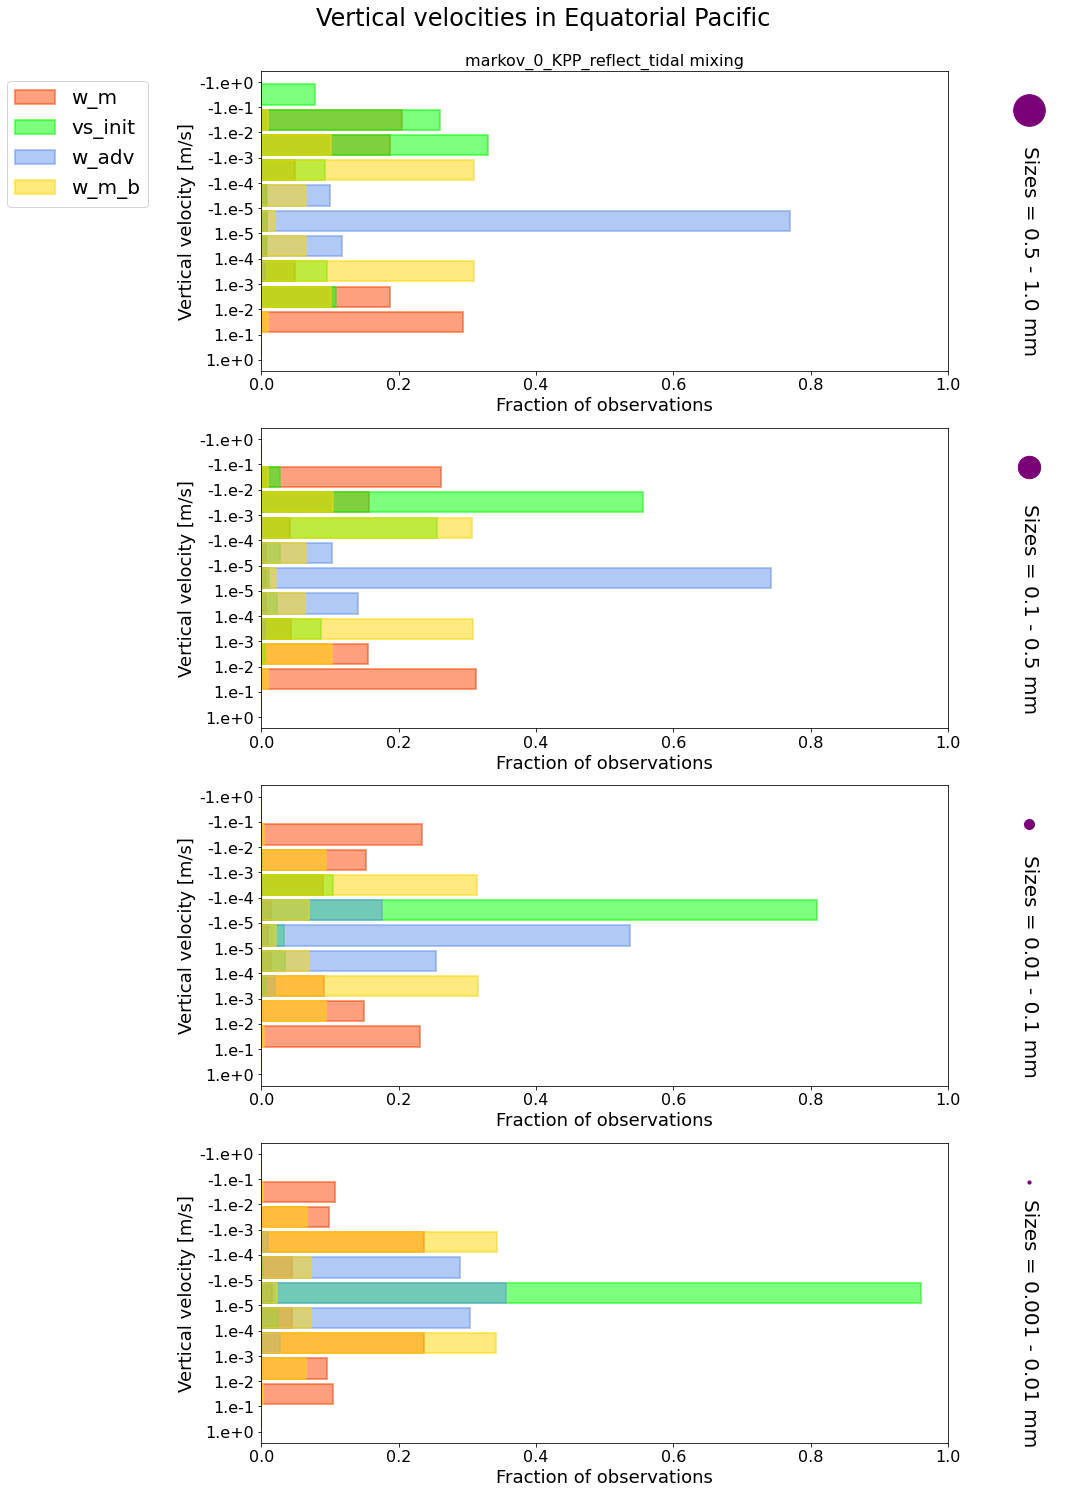

In [35]:
fig = plt.figure(figsize=(15,20),constrained_layout=True)
fig.suptitle('Vertical velocities in '+regions[region], fontsize=24, y=1.03)
gs = gridspec.GridSpec(ncols=2, nrows=4, width_ratios=[1,0.15],figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3, 0])
ax5 = fig.add_subplot(gs[0, 1])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[2, 1])
ax8 = fig.add_subplot(gs[3, 1])
axes = [[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]]

split_ds = list(ds.groupby_bins('r_pl',sizebinedges[::-1]))
for k, ds_r in enumerate(split_ds):
    for j,w in enumerate(w_list):
        axes[0][k].barh(w_centers, w_pdf_sizes[j,k], align='center', alpha=0.5, color=w_vel_cmap[j], edgecolor=w_vel_cmap[j], linewidth=2, label=w)
    axes[0][k].set_xlim(0,1.)
    axes[0][k].set_yticks(w_edges)
    axes[0][k].set_yticklabels(w_bin_str)
    axes[0][k].invert_yaxis()
    axes[0][k].tick_params(axis='both', labelsize=16)
    axes[0][k].set_xlabel('Fraction of observations', fontsize=18)
    axes[0][k].set_ylabel('Vertical velocity [m/s]', fontsize=18)
axes[0][0].set_title(mixing+' mixing', fontsize=16)

for k, ds_r in enumerate(split_ds):
    axes[1][k].scatter(0.5,0.87,s=sizebinedges[k]*1000000,color=r_pl_clist[-1])
    axes[1][k].set_ylim(0,1)
    axes[1][k].text(0.5,0.4,'Sizes = '+ str(ds_r[0].left*1000)+' - '+str(ds_r[0].right*1000)+' mm',rotation=270,fontsize=20, horizontalalignment='center',verticalalignment='center')
    axes[1][k].axis('off')
axes[0][0].legend(fontsize=20, bbox_to_anchor=(-0.15, 1))

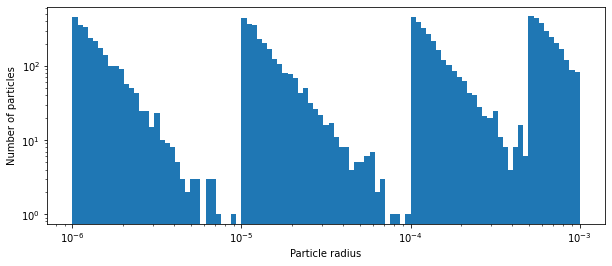

In [10]:
fig = plt.figure(figsize=(10,4)),
ax=plt.axes()
ax.hist(ds['r_pl'],np.logspace(np.log10(ds['r_pl'].min()).round(),np.log10(ds['r_pl'].max()).round(),100))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Number of particles')
ax.set_xlabel('Particle radius')
plt.show()

In [11]:
split_ds = list(ds.groupby_bins('r_pl',sizebinedges[::-1]))

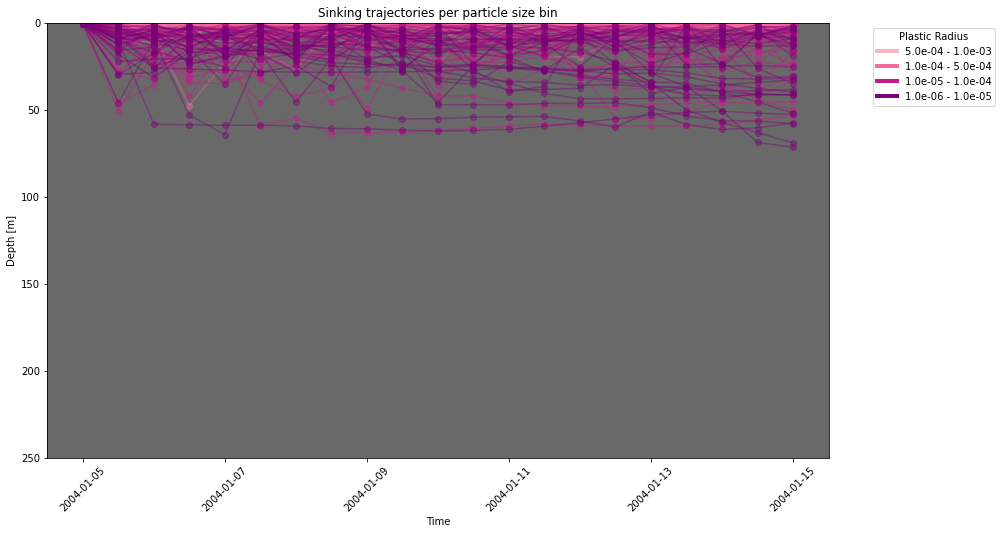

In [12]:
fig = plt.figure(figsize=(14,8))
ax=plt.axes()

for i, r in enumerate(split_ds):
    ax.plot(r[1]['time'].T[:,::f_plt], r[1]['z'].T[:,::f_plt], marker='o', markersize=6, c=r_pl_clist[i], alpha=0.4)
ax.set_facecolor('dimgray')
ax.set_ylim(250,0)
ax.set_title('Sinking trajectories per particle size bin')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Time')
ax.tick_params(axis='x', rotation=45)

custom_lines = [Line2D([0], [0], color=r_pl_clist[0], lw=4),
                Line2D([0], [0], color=r_pl_clist[1], lw=4),
                Line2D([0], [0], color=r_pl_clist[2], lw=4),
                Line2D([0], [0], color=r_pl_clist[3], lw=4)]

ax.legend(custom_lines, ["{left:.1e} - {right:.1e}".format(left=split_ds[0][0].left, right=split_ds[0][0].right), "{:.1e} - {:.1e}".format(split_ds[1][0].left, split_ds[1][0].right), "{:.1e} - {:.1e}".format(split_ds[2][0].left, split_ds[2][0].right), "{:.1e} - {:.1e}".format(split_ds[3][0].left, split_ds[3][0].right)], title='Plastic Radius', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [13]:
ds

<xarray.Dataset>
Dimensions:     (obs: 21, traj: 10000)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float64 -4.0 -4.078 -4.155 ... 5.683 5.487 5.273
    lon         (traj, obs) float64 -140.0 -140.1 -140.2 ... -145.5 -145.3
    z           (traj, obs) float64 ...
    u           (traj, obs) float32 ...
    v           (traj, obs) float32 ...
    w           (traj, obs) float32 ...
    w_adv       (traj, obs) float32 ...
    tpp3        (traj, obs) float32 ...
    d_phy       (traj, obs) float32 ...
    nd_phy      (traj, obs) float32 ...
    a           (traj, obs) float32 ...
    a_coll      (traj, obs) float32 ...
    a_growth    (traj, obs) float32 ...
    a_resp      (traj, obs) float32 ...
    vs          (traj, obs) float32 ...
    w_m         (traj, obs) float32 ...
    w_m_b       (traj, obs) float32 ...
    mld         (traj, obs) float32 ...
    rho_tot     (traj, obs) float32 ...
    r_tot       (traj, obs) float32 ...
    delta_rho   (traj, obs) float32 ...
    KPP         (traj, obs) float32 ...
    K_z_t       (traj, obs) float32 ...
    tau         (traj, obs) float32 ...
    r_pl        (traj) float32 0.0005573303 0.00089890807 ... 1.3471544e-06
    rho_pl      (traj) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2.dev380+gdc6262e2
    parcels_mesh:           spherical
    collision efficiency:   1.0
    mortality rate:         0.39
    background mixing:      tidal

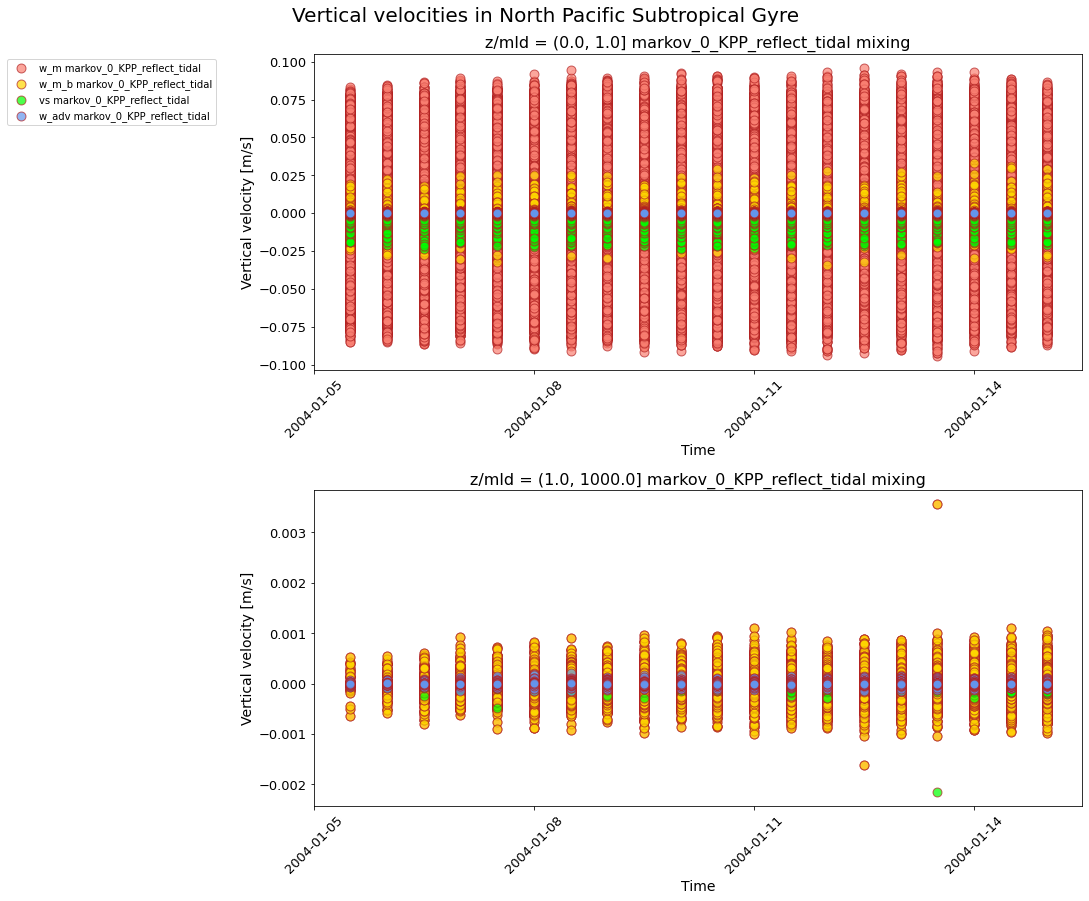

In [24]:
fig = plt.figure(figsize=(15,12),constrained_layout=True)
fig.suptitle('Vertical velocities in '+regions[region], fontsize=20, y=1.03)
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
axes = [ax1, ax2]

split_ds = list(ds.groupby_bins('mld',[0,1,1000]))
for c, ds_g in enumerate(split_ds):
    axes[c].scatter(ds_g[1]['time'].astype('O'), ds_g[1]['w_m'], c=w_vel_cmap[0], s=80, edgecolor=mixing_cmap[0], alpha=0.7, label = 'w_m '+mixing)
    axes[c].scatter(ds_g[1]['time'].astype('O'), ds_g[1]['w_m_b'], c=w_vel_cmap[3], s=80, edgecolor=mixing_cmap[0], alpha=0.7, label = 'w_m_b '+mixing)
    axes[c].scatter(ds_g[1]['time'].astype('O'), ds_g[1]['vs'], c=w_vel_cmap[1], s=80, edgecolor=mixing_cmap[0], alpha=0.7, label = 'vs '+mixing)
    axes[c].scatter(ds_g[1]['time'].astype('O'), ds_g[1]['w_adv'], c=w_vel_cmap[2], s=80, edgecolor=mixing_cmap[0], alpha=0.7, label = 'w_adv '+mixing)
    

    axes[c].set_xlabel('Time', fontsize=14)
    axes[c].set_xticks(times[::6].values)
    axes[c].set_xticklabels(timelabels[::6].values)
    axes[c].tick_params(axis='both', labelsize=13)
    axes[c].tick_params(axis='x', rotation=45)
#         ax.set_ylim(-0.00001,0.00001)
    axes[c].set_ylabel('Vertical velocity [m/s]', fontsize=14)
    axes[c].set_title('z/mld = '+ str(split_ds[c][0])+' '+mixing+' mixing', fontsize=16)
axes[0].legend(bbox_to_anchor=(-0.12, 1), loc='upper right')

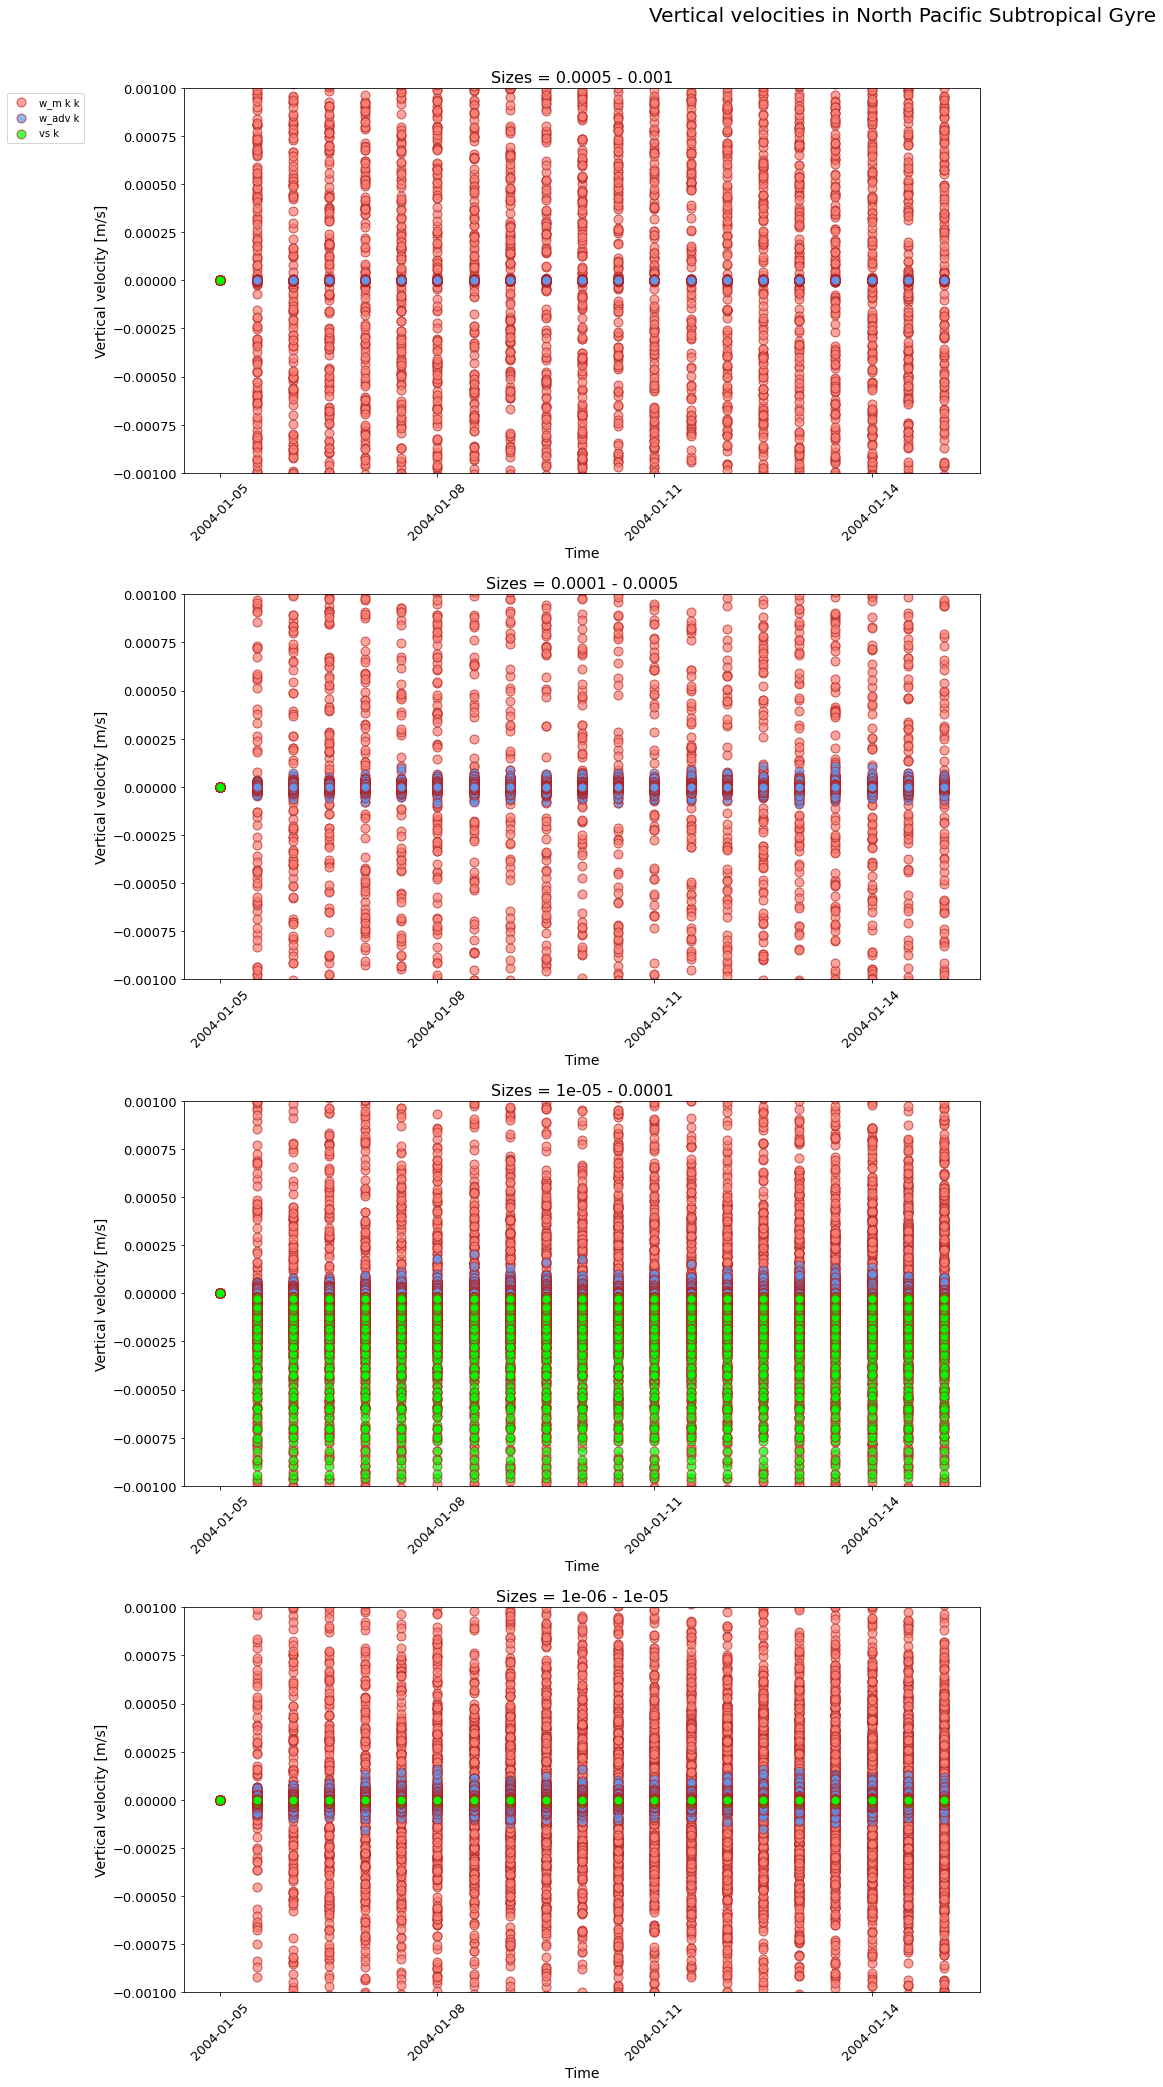

In [32]:
fig = plt.figure(figsize=(25,28),constrained_layout=True)
fig.suptitle('Vertical velocities in '+regions[region], fontsize=20, y=1.03)
gs = gridspec.GridSpec(ncols=2, nrows=4, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3, 0])
axes = [ax1, ax2, ax3, ax4]
locs = ['upper right','upper left']
anchors = [-0.12, 1.05]

split_ds = list(ds.groupby_bins('r_pl',sizebinedges[::-1]))
for c, ds_g in enumerate(split_ds):
    axes[c].scatter(ds_g[1]['time'].astype('O'), ds_g[1]['w_m'], c=w_vel_cmap[0], s=80, edgecolor=mixing_cmap[0], alpha=0.7, label = 'w_m '+mixing[i]+' '+mixing[i])
    axes[c].scatter(ds_g[1]['time'].astype('O'), ds_g[1]['w_adv'], c=w_vel_cmap[2], s=80, edgecolor=mixing_cmap[0], alpha=0.7, label = 'w_adv '+mixing[i])
    axes[c].scatter(ds_g[1]['time'].astype('O'), ds_g[1]['vs_init'], c=w_vel_cmap[1], s=80, edgecolor=mixing_cmap[0], alpha=0.7, label = 'vs '+mixing[i])
    
    axes[c].set_xlabel('Time', fontsize=14)
    axes[c].set_xticks(times[::6].values)
    axes[c].set_xticklabels(timelabels[::6].values)
    axes[c].tick_params(axis='both', labelsize=13)
    axes[c].tick_params(axis='x', rotation=45)
    axes[c].set_ylim(-0.001,0.001)
    axes[c].set_ylabel('Vertical velocity [m/s]', fontsize=14)
    axes[c].set_title('Sizes = '+ str(split_ds[c][0].left)+' - '+str(split_ds[c][0].right), fontsize=16)
axes[0].legend(bbox_to_anchor=(-0.12, 1), loc='upper right')

Text(0.5, 0, 'Wind diffusivity')

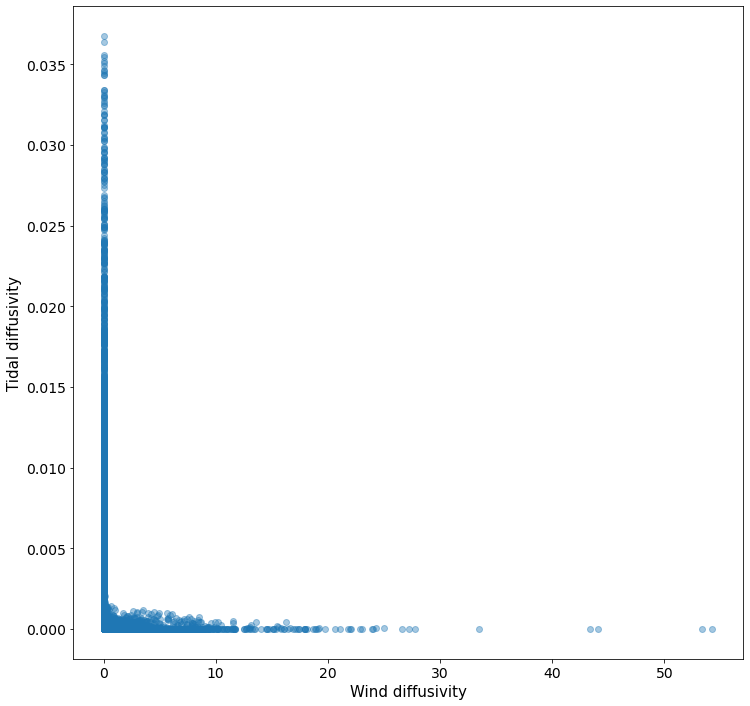

In [15]:
fig =plt.figure(figsize=(12,12))
ax = plt.axes()

ax.scatter(ds['KPP'],ds['K_z_t'], alpha=0.4)
ax.tick_params(axis='both', labelsize=14)
ax.set_ylabel('Tidal diffusivity', fontsize=15)
ax.set_xlabel('Wind diffusivity', fontsize=15)